# Sc2ts vs UShER cophylogenies

To plot cophylogenies, we aim to find identical "representative samples" for Pango lineages that exist in both the UShER tree and the sc2ts tree, and have the same Pango assignment in both. 

To do this, we use the "originating nodes" for each pango from `pango_events_in_arg.csv` identified via the `analysis_pango_events_in_arg` notebook; we ony use the "perfect" originating nodes, defined as those with `"diff" == 0`. To find a representative sample of (say) B.1.1.7 from its origination node, we pick the oldest descendant sample node which has entirely B.1.1.7 samples as descendants in any tree.

To reduce the number of tips to compare, we also remove samples which are known Pango-X recombinants (and descendants of them).

Export using 

```
python src/makepdf.py figures/tanglegram*.svg -o figures
```

In [1]:
import collections
import heapq
import json
import os

from IPython.display import HTML
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tskit
import tszip
import sc2ts

import nb_utils
from nb_utils import DATA_DIR

display(HTML("""<style>@page {margin: 0.2cm;}</style>"""))  # Allow space for tanglegrams

# Get the Viridian ARG
ts = tszip.load(DATA_DIR / "sc2ts_viridian_v1.2.trees.tsz")
df = sc2ts.node_data(ts).set_index("sample_id")

# Get the associated data and join, so that we can use either "pango" or "Viridian_pangolin" defintions
ds = nb_utils.load_dataset()
df = df.join(ds.metadata.as_dataframe(["Viridian_pangolin"]))

# Set which pango designation to use:
# Use "pango" to get the pango designations for all nodes computed by postprocessing the ARG.
# Use "Viridian_pangolin" to use the sample designations provided by Viridian.
Pango = "pango"

pango_lineage_samples = df[df.is_sample].groupby(Pango)['node_id'].apply(list).to_dict()
print(f"ARG has {len(pango_lineage_samples)} pango designations")

hide_progress = False  # Set to `True` and rerun the nodebook to get a nicer version for PDF output

ARG has 2057 pango designations


In [2]:
df_pango_events = pd.read_csv(DATA_DIR / "pango_events_in_arg.csv")
perfect = df_pango_events[df_pango_events["diff"] == 0].set_index('pango')  #  see analysis_pango_events_in_arg.ipynb

In [3]:

pango_representative_sample = {}

def find_first_fully_tracked_sample_by_time(tree, root):
    # Efficiently traverse nodes in time order using a priority queue
    # and return the oldest sample where all descendants are tracked.
    # Takes advantage of the fact that parents have older times than children.
    node_times = tree.tree_sequence.nodes_time
    if root == tskit.NULL:
        root = tree.virtual_root
    
    # Priority queue: (time, node)
    pq = [(-node_times[root], root)]
    while pq:
        time, u = heapq.heappop(pq)
        # Skip nodes with no tracked samples
        if tree.num_tracked_samples(u) == 0:
            continue
        # Check if this node is fully tracked and also in the reduced UShER tree
        if tree.num_samples(u) == tree.num_tracked_samples(u) and tree.is_sample(u):
            return u
        # Add children to priority queue (they have younger times)
        for child in tree.children(u):
            heapq.heappush(pq, (-node_times[child], child))
    return None  # No fully tracked node found


def representative_node(ts, pango, pango_root):
    # descend from the root pango in each tree, but avoid any subtree that has no
    # tracked_samples
    for tree in ts.trees(tracked_samples=pango_lineage_samples[pango]):
        nd = find_first_fully_tracked_sample_by_time(tree, pango_root)
        if nd is not None:
            return nd

# For speed, simplify the ARG down to a set of subgroups of pango samples
# before looking for the sample descendants. Note that th could be much
# more efficient if we use the new ARG interface.
pangos = list(pango_lineage_samples.keys())
n_batches = int(np.sqrt(len(pangos)))
poor_orig_nd_pct = {}
no_valid_orig_nd = []

pango_origin = {}
for i in tqdm(np.arange(n_batches), disable=hide_progress):
    batch = pangos[i::n_batches]
    tmp_df = df.set_index("node_id")
    tmp_df = tmp_df.loc[np.isin(df[Pango], batch)]
    samples = np.array([u for b in batch for u in pango_lineage_samples[b]])
    simp_ts = ts.simplify(samples, keep_unary=True, filter_nodes=False)
    for pango in tqdm(batch, leave=False, disable=hide_progress):
        if pango not in perfect.index:
            no_valid_orig_nd.append(pango)
        else:
            best_nd = representative_node(ts, pango, perfect.loc[pango, 'root'])
            if best_nd is not None:
                vv = df.loc[df.node_id == best_nd, Pango].values
                assert len(vv) == 1 and vv[0] == pango
                pango_representative_sample[pango] = best_nd

sts = ts.simplify(
    [v for k, v in pango_representative_sample.items()
     if not k.startswith("X")
    ], keep_unary=True, filter_nodes=False)

print(f"Found {len(pango_representative_sample)} Pango sample nodes out of {len(pango_lineage_samples)} pango groups")
print(f"The following {len(no_valid_orig_nd)} pango designations were omitted due to having no perfect pango origination node")
print(" " + ", ".join(no_valid_orig_nd))

print(f"Simplified ARG to representative non-pangoX samples: {sts.num_trees} trees and {sts.num_samples} samples")

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Found 1470 Pango sample nodes out of 2057 pango groups
The following 585 pango designations were omitted due to having no perfect pango origination node
 AY.5.3, B.1.1.135, B.1.1.274, B.1.1.59, B.28, BA.2.71, BA.5.11, BA.5.2.57, BN.1.3.7, BQ.1.1.32, AY.105, AY.5.4, B.1.1.419, B.1.1.61, B.1.143, B.1.320, BA.2.13, BA.2.34, BA.2.72, AY.106, AY.4.11, AY.5.5, B.1.1.204, B.1.1.277, B.1.1.62, B.1.145, B.1.422, BA.2.73, BA.5.2.1, BA.5.2.59, BF.38, AY.107, AY.4.12, B.1.1.138, B.1.258, B.1.596, BA.1.1.6, BA.2.14, BA.2.36, BA.4.6.4, BA.5.2.6, BQ.1.1.36, DC.1, P.1.13, B.1.1.28, B.1.1.355, B.1.1.426, B.1.324, BA.1.1.7, BA.2.37, BA.4.6.5, BA.5.2.12, BF.39, BQ.1.1.37, CE.1, P.1.14, XBB.1.5.25, AY.109, AY.20, AY.92, B.1.1.280, B.1.1.356, B.1.332, B.1.363, B.1.518, BA.1.1.8, BA.2.38, BG.5, BQ.1.1.38, BQ.1.11, CF.1, DE.2, EE.3, A.2.5.1, AY.52, B.1.1.141, B.1.1.359, B.1.1.70, B.1.153, B.1.199, B.1.366, B.1.520, B.33, BA.1.1.9, BA.4.8, BA.5.2.62, BF.4, BQ.1.11.1, P.1.16, XBB.1.11, XBB.1.5.28, A.2.5.2, AY.

In [4]:
# Are there any samples with a recombination node immediately above

sts = ts.simplify(
    [v for k, v in pango_representative_sample.items()
     if not k.startswith("X")
    ], keep_unary=True, filter_nodes=False)

recombinants = list(np.where(sts.nodes_flags & sc2ts.NODE_IS_RECOMBINANT)[0])
## Make a dictionary, `sample_desc`, with the descendants of each recombinant (and the rewired recombinants)
sample_desc = collections.defaultdict(set)
for tree in sts.trees():
    for u in recombinants:
        if tree.num_samples(u) > 0:
            sample_desc[u] |= set(tree.samples(u))

if not hide_progress:
    for k, v in sample_desc.items():
        print(f"Node {k} ({ts.node(k).metadata['pango']}): {len(v)} descendant pangos")

one_sample_re = {list(v)[0] for v in sample_desc.values() if len(v) <= 1}

internal_nodes = set(sts.edges_parent)

sts = ts.simplify([
    v for k, v in pango_representative_sample.items()
    if (
        v not in one_sample_re and
        v not in internal_nodes and
        not k.startswith("X") and
        v not in sample_desc[1396207]  # Exclude descendants of XBB (some of these do not start with an X)
    )
], keep_unary=True, filter_nodes=False)

if not hide_progress:
    print(
        "After removing singleton Pangos below a RE node, and further PangoX descendants "
        f" the ARG has {sts.num_trees} trees and {sts.num_samples} pangos")

sample_desc = collections.defaultdict(set)
for tree in sts.trees():
    for u in recombinants:
        if tree.num_samples(u) > 0:
            sample_desc[u] |= set(tree.samples(u))
if not hide_progress:
    for k, v in sample_desc.items():
        print(f"Node {k} ({ts.node(k).metadata['pango']}): {len(v)} descendant samples")

sample_desc[None] = set(sts.samples()) - set().union(*list(sample_desc.values()))

if not hide_progress:
    print(len(sample_desc[None]), "samples not under a RE node")

Node 908970 (BA.1): 1 descendant pangos
Node 1189192 (BA.5): 289 descendant pangos
Node 1253364 (BA.5.2.1): 1 descendant pangos
Node 1279026 (BA.5.1): 1 descendant pangos
Node 1338895 (BA.4.6): 1 descendant pangos
Node 1391762 (BF.7.13): 1 descendant pangos
Node 1396207 (XBB): 43 descendant pangos
Node 1418709 (BQ.1.21): 1 descendant pangos
Node 1030562 (BA.2): 288 descendant pangos
After removing singleton Pangos below a RE node, and further PangoX descendants  the ARG has 3 trees and 1282 pangos
Node 1189192 (BA.5): 286 descendant samples
Node 1030562 (BA.2): 286 descendant samples
996 samples not under a RE node


In [5]:
if not hide_progress:
    print("""
        The 3 trees correspond to 2 recombination nodes.
        * 1189192 is the BA.5 recombinant: this may be wrongly identified: see description in supplementary material
        * 1030562 is probably wrong: the recombination node is on the far RHS @ 27382, and includes only 5 sites / 3 loci that differ between parents there

        This can be seen in the copying patterns below
    """)
    display(HTML(
            "<style>table.copying-table {font-size: 8px} table.copying-table .pattern td {font-size: 0.5em; width:0.2em}</style>" +
            sc2ts.info.CopyingTable(ts, 1189192).html(child_label="1189192", show_bases=None)
        ))
    display(HTML(
        "<style>table.copying-table {font-size: 8px} table.copying-table .pattern td {font-size: 0.5em; width:0.2em}</style>" +
        sc2ts.info.CopyingTable(ts, 1030562).html(child_label="1030562", show_bases=None)
    ))


        The 3 trees correspond to 2 recombination nodes.
        * 1189192 is the BA.5 recombinant: this may be wrongly identified: see description in supplementary material
        * 1030562 is probably wrong: the recombination node is on the far RHS @ 27382, and includes only 5 sites / 3 loci that differ between parents there

        This can be seen in the copying patterns below
    


pos,686,687,688,689,690,691,692,693,694,9866,12160,14277,16342,21765,21766,21767,21768,21769,21770,22917,23018,23040,26529,26858,27259,27382,27383,27384,27788,27889,28724,29754
ref,A,A,G,T,C,A,T,T,T,C,G,G,T,T,A,C,A,T,G,T,T,A,G,C,A,G,A,T,G,C,C,C
P0,—,—,—,—,—,—,—,—,—,,,,,—,—,—,—,—,—,,,,,,,,,,,,,
1189192,,,,,,,,,,,,,,—,—,—,—,—,—,,,,,,,,,,,,,
P1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mut,->A,->A,->G,->T,->C,->A,->T,->T,->T,,,,,,,,,,,,,,G>A,,C>A,,,,,C>T,,


pos,44,670,2470,2790,2832,4184,4321,5386,6513,6514,6515,7926,8393,9344,9424,9534,9866,10198,10447,11283,11284,11285,11286,11287,11292,11293,11294,11295,11296,11537,12880,13195,15240,15714,16342,17410,19955,20055,21618,21633,21634,21635,21636,21637,21638,21639,21640,21641,21762,21765,21766,21767,21768,21769,21770,21846,21987,21988,21989,21990,21991,21992,21993,21994,21995,22195,22197,22198,22200,22202,22204,22599,22673,22688,22775,22786,22898,23048,23202,24130,24503,25855,26060,26530,26858,27382,27383,27384,29510,29754
ref,C,T,C,C,A,G,C,T,G,T,T,C,G,C,A,C,C,C,G,G,T,T,T,G,G,T,T,T,T,A,C,T,C,C,T,C,C,A,C,T,A,C,C,C,C,C,T,G,C,T,A,C,A,T,G,C,G,T,G,T,T,T,A,T,T,T,T,A,T,C,T,G,T,A,G,A,G,G,C,C,C,G,C,A,C,G,A,T,A,C
P0,,,,,,,,,,,,,,,,,,,,,,,,,—,—,—,—,—,,,,,,,,,,,—,—,—,—,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1030562,,,,,,,,,,,,,,,,,,,,,,,,,—,—,—,—,—,,,,,,,,,,,—,—,—,—,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1,,,,,,,,,—,—,—,,,,,,,,,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,,,,,,—,—,—,—,—,—,,—,—,—,—,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mut,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [6]:
tables = sts.dump_tables()
tables.reference_sequence.clear()
bp_1030562 = (sts.edges_right[sts.edges_child == 1030562]).min()
display(HTML(
    'We also treat descendants of the 1030562 fake "recombinant" ' +
    '(see <a href="https://github.com/jeromekelleher/sc2ts-paper/discussions/672">https://github.com/jeromekelleher/sc2ts-paper/discussions/672</a>) ' +
    f'as non-recombining, by trimming away the RHS from {bp_1030562} onwards.'
))
tables.keep_intervals([[0, bp_1030562]], simplify=False)
tables.trim()
core_sc2ts = tables.tree_sequence()
core_df = sc2ts.node_data(core_sc2ts)
core_df_samples = core_df[core_df.is_sample]
core_df_samples.set_index("sample_id", inplace=True)
core_df_samples = core_df_samples.join(ds.metadata.as_dataframe(["Date_tree", "Viridian_pangolin"]))

core_sc2ts_map = {}
core_sc2ts_pango_map = {}
for row in core_df_samples.itertuples():
    core_sc2ts_map[row.Index] = row.node_id
    core_sc2ts_pango_map[getattr(row, Pango)] = row.Index
    
assert core_sc2ts.num_trees == 2  # 1 breakpoint

In [7]:
uts = tszip.load("../data/usher_viridian_inter_v1.2.trees.tsz")
if not hide_progress:
    print(f"Using UShER tree with {uts.num_samples} samples")

Using UShER tree with 2475418 samples


In [8]:
usher_map = {}
usher_pango = collections.defaultdict(list)
for u in tqdm(uts.samples(), disable=hide_progress):
    nd = uts.node(u)
    usher_map[nd.metadata['sample_id']] = u

  0%|          | 0/2475418 [00:00<?, ?it/s]

In [9]:
joint_keys = core_sc2ts_map.keys() & usher_map.keys()
display(HTML(f"By comparing sample ids with the UShER tree, we find {len(joint_keys)} shared Pango-representative samples"))
pangos = {}  # Map the key (e.g. ERR10001879) to a pango
for k in tqdm(joint_keys, disable=hide_progress):
    try:
        pangos[k] = df.loc[k, Pango]
    except IndexError:
        print(k, "not found")
reverse_pangos = {v: k for k, v in pangos.items()}
pango_numbers = {k: len(pango_lineage_samples[pangos[k]]) for k in joint_keys}

  0%|          | 0/1266 [00:00<?, ?it/s]

In [10]:
if not hide_progress:
    print("Aligning times between the Usher tree and the sc2ts tree")
core_sc2ts_nodes = np.array([core_sc2ts_map[k] for k in joint_keys])
usher_nodes = np.array([usher_map[k] for k in joint_keys])
time_diff = np.round((uts.nodes_time[usher_nodes]- core_sc2ts.nodes_time[core_sc2ts_nodes]).mean(), 5)
tables = uts.dump_tables()
tables.nodes.time = tables.nodes.time - time_diff
tables.mutations.time = tables.mutations.time - time_diff
usher_ts = tables.tree_sequence()

Aligning times between the Usher tree and the sc2ts tree


In [11]:
def sc2ts_tanglegram(
    ts,
    sample_to_pango,
    size=(800, 800),
    time_scale="rank",
    x_ticks=None,
    line_gap=40,
    separation=100,
    style="",
    label="",
    omit_sites=None,
    sample_fontsize="8px",
    **kwargs
):
    if omit_sites is None:
        omit_sites = True
    if x_ticks is not None:
        if time_scale=="rank": 
            # rescale the X ticks on each side
            node_ids = np.array(list(ts.first().nodes()))
            times = {t : i for i, t in enumerate(np.unique(ts.nodes_time[node_ids]))}
            # slight hack - just find the nearest time
            x_ticks_lft = {}
            for key, lab in x_ticks.items():
                closest_time = min(times.keys(), key=lambda x: abs(x - key))
                x_ticks_lft[times[closest_time]] = lab
            node_ids = np.array(list(ts.last().nodes()))
            times = {t : i for i, t in enumerate(np.unique(ts.nodes_time[node_ids]))}
            # slight hack - just find the nearest time
            x_ticks_rgt = {}
            for key, lab in x_ticks.items():
                closest_time = min(times.keys(), key=lambda x: abs(x - key))
                x_ticks_rgt[times[closest_time]] = lab
            x_ticks = (x_ticks_lft, x_ticks_rgt)
            
        else:
            x_ticks = (x_ticks, x_ticks)
    return nb_utils.tanglegram(
        ts, size=size, omit_sites=omit_sites, time_scale=time_scale, line_gap=line_gap,
        titles=(f"Sc2ts {label}", f"UShER {label}"),
        style="g.tangle_lines line {stroke: lightgrey} .sample .lab {font-size: %s}" % sample_fontsize + style,
        node_labels={u: sample_to_pango[ts.node(u).metadata['sample_id']] for u in ts.samples()},
        separation=separation,
        x_ticks=x_ticks,
        **kwargs
    )

In [12]:
# Find the parents of BA.5
edges = core_sc2ts.edges_child == 1189192
ba5_p = {k: v for k, v in zip(core_sc2ts.edges_right[edges], core_sc2ts.edges_parent[edges])}
ba5_p = [ba5_p[k] for k in sorted(ba5_p.keys())]
ba5_parents = {}
for p in df.loc[np.isin(df.node_id, ba5_p), "pango"]:
    try:
        ba5_parents[reverse_pangos[p]] = p
    except KeyError:
        print(f"BA.5 parent {p} not in reduced tree")
if not hide_progress:
    print("BA.5 parents are", ba5_parents)

BA.5 parent BA.2 not in reduced tree
BA.5 parents are {'SRR18848038': 'BA.4'}


In [13]:
def make_joint_ts(ts1, ts2, metadata_name1, metadata_name2):
    """
    Combine two tree sequences of one tree each into a single tree sequence of
    2 trees assuming the samples are in the same order in both.
    """
    if ts1.num_trees > 1 or ts2.num_trees > 1:
        raise ValueError(
            f"Found {ts1.num_trees} trees in the first ts and {ts2.num_trees} trees in the second ts. Expected exactly one tree in each."
        )
    tables = ts1.dump_tables()
    tables.sequence_length = ts1.sequence_length + ts2.sequence_length
    node_map = np.arange(ts2.num_nodes)
    for node in ts2.nodes():
        if not node.is_sample():
            md = {'sample_id': node.metadata['sample_id'], 'pango': node.metadata.get('pango', ''), 'scorpio': node.metadata.get('scorpio', '')}
            node_map[node.id] = tables.nodes.append(node.replace(metadata=md))
    for edge in ts2.edges():
        tables.edges.add_row(child=node_map[edge.child], parent=node_map[edge.parent], left=ts1.sequence_length, right=tables.sequence_length)
    tables.sort()

    return tables.tree_sequence()


import nb_utils
min_samples = 10
use = [k for k in joint_keys if pango_numbers[k] >= min_samples]
display(HTML(
    f"Finally, to create manageably-sized phylogeny plots, we restrict to Pango lineages accounting for >= {min_samples} samples, "
    "and break the cophylogenies down into a base tree and several subtrees."
))

base_ids = sample_desc[None] - sample_desc[1189192]

subtree_samples = {
    "base tree": [k for k in use if core_sc2ts_map[k] in base_ids],
    "BA.5 subtree": [k for k in use if core_sc2ts_map[k] in sample_desc[1189192]],
}

for tree in sts.trees():
    for u in [200039, 822854]:
        if tree.num_samples(u) > 0:
            sample_desc[u] |= set(tree.samples(u))

two_tree_ts = {}
node_map = {}
total = 0
for subtree, sample_names in subtree_samples.items():
    sc2_ts, node_map[subtree] = core_sc2ts.simplify(
        [core_sc2ts_map[k] for k in sample_names], keep_input_roots=True, map_nodes=True
    )
    two_tree_ts[subtree] = make_joint_ts(
        sc2_ts,
        usher_ts.simplify([usher_map[k] for k in sample_names], keep_input_roots=True),
        "sample_id", "sample_id"
    )


# Make a subtree of just the Delta samples
delta_samples = node_map['base tree'][np.array([s for s in sample_desc[200039]])]
delta_samples = delta_samples[delta_samples != tskit.NULL]  # remove e.g. those with <10 samples)
two_tree_ts['Delta subtree'] = two_tree_ts['base tree'].simplify(delta_samples, keep_input_roots=True)

# Make a subtree of just the BA.2 samples
ba2_samples = node_map['base tree'][np.array([s for s in sample_desc[822854]])]
ba2_samples = ba2_samples[ba2_samples != tskit.NULL]  # remove e.g. those with <10 samples)
two_tree_ts['BA.2 subtree'] = two_tree_ts['base tree'].simplify(ba2_samples, keep_input_roots=True)

# remove those samples from base tree, but leave a stub node to indicate where they belong
delta_roots = [tree.mrca(*delta_samples) for tree in two_tree_ts['base tree'].trees()]
ba2_roots = [tree.mrca(*ba2_samples) for tree in two_tree_ts['base tree'].trees()]
tables = two_tree_ts['base tree'].dump_tables()
for target, roots in zip([200039, 822854], (delta_roots, ba2_roots)):
    md = sts.node(target).metadata
    md['sample_id'] = str(target)
    fake_nd = tables.nodes.add_row(
        flags=tskit.NODE_IS_SAMPLE, time=min(two_tree_ts['base tree'].nodes_time[roots]) - 0.1, metadata=md
    )
    for u in roots:
        edge = np.where(two_tree_ts['base tree'].edges_child == u)[0]
        assert len(edge) == 1
        edge = edge[0]
        tables.edges[edge] = tables.edges[edge].replace(child=fake_nd)
tables.sort()
use = (tables.nodes.flags & tskit.NODE_IS_SAMPLE) != 0
use[delta_samples] = False
use[ba2_samples] = False
tables.simplify(np.where(use)[0], keep_input_roots=True)
two_tree_ts['base tree'] = tables.tree_sequence()

if not hide_progress:
    for (name, jts) in two_tree_ts.items():
        print(jts.num_samples)
        print(f"Joint tree sequence of {name} has {jts.num_samples} samples, classified as:")
        scorpio_counts = collections.Counter(
            [jts.node(u).metadata['scorpio'] for u in jts.samples()]
        )
        print("\n".join([f"\t{'unclassified' if k == "nan" else k}: {v} samples" for k, v in scorpio_counts.items()]))
        total += jts.num_samples
    
    print(f"Total number of plotted Pangos={total}")


405
Joint tree sequence of base tree has 405 samples, classified as:
	.: 374 samples
	Gamma (P.1-like): 4 samples
	A.23.1-like: 1 samples
	B.1.617.1-like: 1 samples
	B.1.1.318-like: 4 samples
	Omicron (BA.1-like): 5 samples
	Epsilon (B.1.429-like): 1 samples
	Beta (B.1.351-like): 3 samples
	Alpha (B.1.1.7-like): 1 samples
	Lambda (C.37-like): 1 samples
	Eta (B.1.525-like): 1 samples
	Mu (B.1.621-like): 3 samples
	AV.1-like: 1 samples
	Zeta (P.2-like): 1 samples
	Epsilon (B.1.427-like): 1 samples
	Iota (B.1.526-like): 1 samples
	Delta (B.1.617.2-like): 1 samples
	Omicron (BA.2-like): 1 samples
187
Joint tree sequence of BA.5 subtree has 187 samples, classified as:
	Omicron (BA.5-like): 187 samples
104
Joint tree sequence of Delta subtree has 104 samples, classified as:
	Delta (B.1.617.2-like): 96 samples
	Delta (B.1.617.2-like) +K417N: 2 samples
	Delta (AY.4-like): 5 samples
	Delta (AY.4.2-like): 1 samples
118
Joint tree sequence of BA.2 subtree has 118 samples, classified as:
	Omicron 

In [14]:
import datetime

x_ticks = {}
zero = datetime.date.fromisoformat(core_sc2ts.metadata["time_zero_date"])
months = list(range(1, 13))  # 1 to 12

target_dates = (
    [datetime.date(2023, 2, 1)] + [datetime.date(2023, 1, 1)] + # 2023: Jan, Feb only
    [datetime.date(year, month, 1) for year in [2022, 2021, 2020, 2019] for month in reversed(months)]
)
for target_date in target_dates:
    days_difference = (zero - target_date).days
    x_ticks[days_difference] = target_date.strftime("%Y-%m")

In the following cophylogeny tanglegram plots, we have used _dendroscope_ (Huson and Scornavacca, DOI:10.1093/sysbio/sys062) to untangle the trees. We have found this to be the most effective software for untangling trees with polytomies.

In [15]:
dendroscope_binary = "/Applications/Dendroscope/Dendroscope.app/Contents/MacOS/JavaApplicationStub"

import tempfile
import subprocess
import re

def run_dendroscope_untangle(ts_2_trees):
    # Uses the Neighbor-net heuristic algorithm, which works well with polytomies
    assert ts_2_trees.num_trees == 2
    with tempfile.TemporaryDirectory() as tmpdirname:
        newick_path = os.path.join(tmpdirname, "cophylo.nwk")
        command_path = os.path.join(tmpdirname, "commands.txt")
        with open(newick_path, "wt") as file:
            for tree in ts_2_trees.trees():
                print(tree.as_newick(), file=file)
        with open(command_path, "wt") as file:
            print(f"open file='{newick_path}';", file=file)
            print("compute tanglegram method=nnet", file=file)
            print(
                f"save format=newick file='{newick_path}'", file=file
            )  # overwrite
            print("quit;", file=file)
        subprocess.run([dendroscope_binary, "-g", "-c", command_path])
        order = []
        with open(newick_path, "rt") as newicks:
            for line in newicks:
                # hack: use the order of `nX encoded in the string
                order.append([int(n[1:]) for n in re.findall(r"n\d+", line)])
    return order

In [16]:
# Use the run_dendroscope_untangle above: this can take hours, so we save the results

orders = {}
for subtree, ts2 in two_tree_ts.items():
    path = os.path.join("layout_data", f"tanglegram_order-{subtree}-{Pango}{min_samples}.json")
    if not os.path.exists(path):
        print(f"Running untangling algorithm for {subtree}")
        orders[subtree] = run_dendroscope_untangle(ts2)
        with open(path, "wt") as f:
            f.write(json.dumps(orders[subtree]))
    else:
        with open(path, "rt") as f:
            orders[subtree] = json.loads(f.read())


Running untangling algorithm for base tree
Version   Dendroscope (version 3.8.10, built 6 Sep 2023)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2023  Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms of the GNU General Public License, Version 3.
Java version: 18.0.2.1; max memory: 15.8G
Java version: 18.0.2.1

Trees loaded: 2
Compute tanglegram: Initialization
Neighbor-net heuristic
The minimal crossing number found is 0
Time needed for computation: 4 min.
--------------------------
Saving file: /var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/tmppmm9h1em/cophylo.nwk
written 2 trees
Running untangling algorithm for BA.5 subtree
Version   Dendroscope (version 3.8.10, built 6 Sep 2023)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2023  Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms o

In [17]:
from hashlib import blake2b

def plot_tanglegram(ts, name, orders, sample_to_pango, legend_func=None, path=None, **kwargs):
    
    def hash_samples_under_node(tree, u):
        return blake2b(" ".join(str(u) for u in sorted(tree.samples(u))).encode(), digest_size=20).digest()

    scorpios = collections.defaultdict(list)
    sample_id_to_node_id = {}
    for u in ts.samples():
        nd = ts.node(u)
        s = nd.metadata['scorpio']
        s = "basal" if s=="." else s
        scorpios[s].append(u)
        sample_id_to_node_id[nd.metadata["sample_id"]] = u
    scorpios = {k: scorpios[k] for k in sorted(scorpios.keys(), key=lambda x: -len(scorpios[x]))}

    ltree, rtree = ts.first(), ts.last()
    l_hashes = {hash_samples_under_node(ltree, u): u for u in ltree.nodes() if not ltree.is_sample(u)}
    r_hashes = {hash_samples_under_node(rtree, u): u for u in rtree.nodes() if not rtree.is_sample(u)}

    joint_hashes = l_hashes.keys() & r_hashes.keys()

    colours = ["#77AADD", "#EE8866", "#EEDD88", "#FFAABB", "#44BB99", "#BBCC33", "#AAAA00", "#99DDFF",]

    tg, lft_map, rgt_map = sc2ts_tanglegram(ts, sample_to_pango, label=name, order=orders, symbol_size=3, x_axis=True, **kwargs)
    styles = ['.y-axis .ticks .lab {font-size: 10px; font-family: "Arial Narrow"}']
    # Add styles for edges and shared nodes
    for nd_map, cls, hashes in zip([lft_map, rgt_map], ["lft_tree", "rgt_tree"], [l_hashes, r_hashes]):
        styles += [
            (
                ",".join([f".{cls} > .tree .n{nd_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}" +
                ",".join([f".{cls} > .tree .n{nd_map[u]}.sample .sym" for u in v]) + f"{{fill: {c}}}"
            )
            for c, (k, v) in zip(colours, scorpios.items())
        ]
        styles += [
            ",".join([f".{cls} > .tree .n{nd_map[hashes[hsh]]} > .sym" for hsh in joint_hashes]) +
            "{r: 2px; fill: magenta; stroke: black;}"
        ]

    legend = "" if legend_func is None else legend_func(colours, scorpios.keys())
    for nd in ts.nodes():
        if nd.metadata['sample_id'] == '200039':
            styles.append(
                f".lft_tree > .tree .node.n{lft_map[nd.id]} .sym " +
                "{transform: translate(0px, 40px) scale(2.5); stroke: black; stroke-width: 0.5px; fill: #FFFF00}" +
                f".rgt_tree > .tree .node.n{rgt_map[nd.id]} .sym " +
                "{transform: translate(0px, 40px) scale(2.5); stroke: black; stroke-width: 0.5px; fill: #FFFF00}"
            )
        elif nd.metadata['sample_id'] == '822854':
            styles.append(
                f".lft_tree > .tree .node.n{lft_map[nd.id]} .sym " +
                "{transform: translate(0px, 31px) scale(2.5) rotate(45deg); stroke: black; stroke-width: 0.5px; fill: #FFFF00;}" +
                f".rgt_tree > .tree .node.n{rgt_map[nd.id]} .sym " +
                "{transform: translate(0px, 31px) scale(2.5) rotate(45deg); stroke: black; stroke-width: 0.5px; fill: #FFFF00;}"
            )
        elif sample_to_pango.get(nd.metadata['sample_id']) == 'BA.4':
            styles.append(
                f".lft_tree > .tree .node.n{lft_map[nd.id]} .sym " +
                "{transform: translate(0px, 50px) scale(2.5); stroke: black; stroke-width: 0.5px; fill: #FFFF00;}" +
                f".rgt_tree > .tree .node.n{rgt_map[nd.id]} .sym " +
                "{transform: translate(0px, 50px) scale(2.5); stroke: black; stroke-width: 0.5px; fill: #FFFF00;}"
            )
    tg.preamble = "<style>" + "".join(styles) + "</style>" + tg.preamble + legend  
    svg = tg.draw()
    if path is not None:
        with open(path, "wt") as f:
            f.write(svg)
    return svg

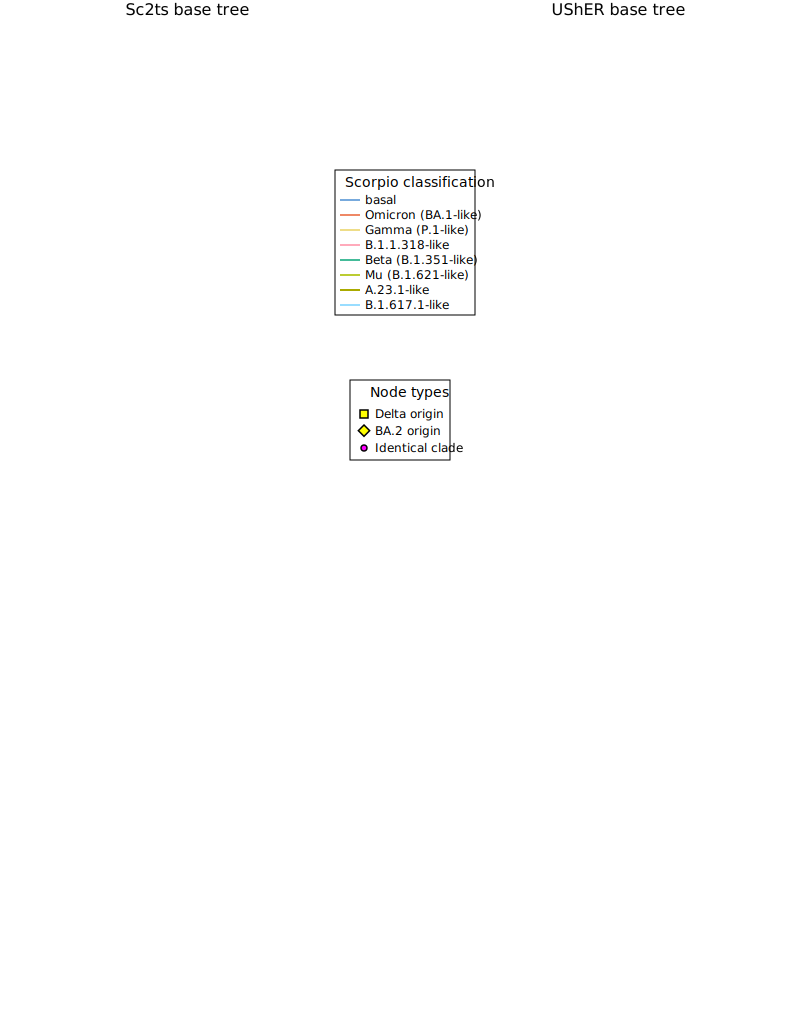

In [27]:
def base_legend(colours, labels):
    return (
        '<g transform="translate(335 170)">' +
        '<rect x="0" y="0" width="140" height="145" fill="white" stroke="black" />' +
        '<text x="10" y="17" font-style="italic" font-size="14px">Scorpio classification</text>' +
        "".join([
            (f'<line x1="5" x2="25" y1="{30 + 15*i}" y2="{30 + 15*i}" stroke="{c}" stroke-width="2" />'
             f'<text x="30" y="{34 + 15 * i}" font-size="12px">{label}</text>'
            )
            for i, (c, label) in enumerate(zip(colours, labels))
        ]) +
        '</g>' +
        '<g transform="translate(350 380)">' +
        '<rect x="0" y="0" width="100" height="80" fill="white" stroke="black" />' +
        '<text x="20" y="17" font-style="italic" font-size="14px">Node types</text>' +
        '<rect x="10" y="30" height="8" width="8" stroke="black" stroke-width="1.5" fill="#FFFF00"/>' +
        '<text x="25" y="38" font-size="12px">Delta origin</text>' +
        '<rect height="8" width="8" stroke="black" stroke-width="1.5" transform="translate(14, 45) rotate(45)" fill="#FFFF00" />' +
        '<text x="25" y="55" font-size="12px">BA.2 origin</text>' +
        '<circle cx="14" cy="68" r="3" stroke="black" stroke-width="1.5" fill="magenta" />' +
        '<text x="25" y="72" font-size="12px">Identical clade</text>' +
        '</g>'
    )

name = "base tree"

plot_tanglegram(
    two_tree_ts[name], name, orders[name],
    {**pangos, **{"200039": "DELTA ROOT", "822854": "BA.2 ROOT"}},
    size=(750, 1020),
    x_ticks={k: v for k, v, in x_ticks.items() if 700 < k < 1150},
    legend_func=base_legend,
    x_label="",
    separation=120,
    sample_fontsize="4px",
    line_gap=25,    
    path=f'../figures/tanglegram_{name.replace(" ", "_")}.svg',
)

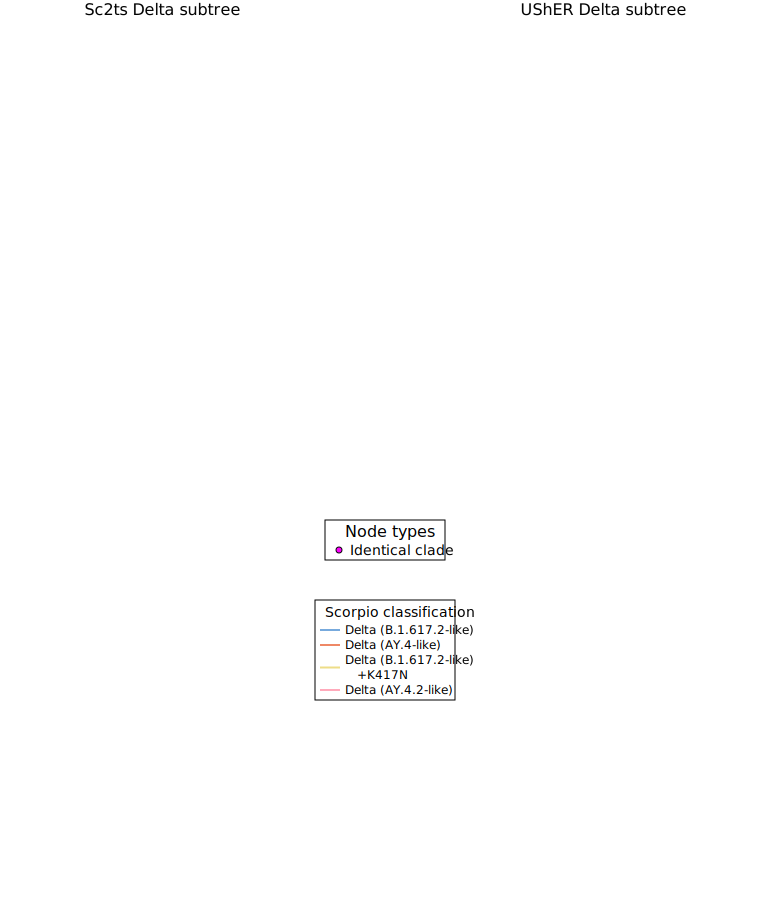

In [19]:
def delta_legend(colours, labels):
    elems = {}
    i = 0
    # Hack to get a narrower legend by wrapping legend labels on "+"
    for c, label in zip(colours, labels):
        svgline = '<line x1="5" x2="25" y1="{y}" y2="{y}" stroke="{c}" stroke-width="2" />'
        if "+" not in label:
            elems[i] = (svgline.format(c=c, y=30 + 15*i), label)
            i += 1
        else:
            label = label.split("+")
            label[1] = "   +" +  label[1]
            for l in label:
                elems[i] = ("" if "+" in l else svgline.format(c=c, y=30 + 15*(i+0.5)), l)
                i += 1
    return (
        '<g transform="translate(315 600)">' +
        '<rect x="0" y="0" width="140" height="100" fill="white" stroke="black" />' +
        '<text x="10" y="17" font-style="italic" font-size="14px">Scorpio classification</text>' +
        "".join([
            f'{svgline}<text xml:space="preserve" x="30" dy="{34 + 15 * i}" font-size="12px">{label}</text>'
            for i, (svgline, label) in elems.items()
        ]) +
        '</g>' +
        '<g transform="translate(325 520)">' +
        '<rect x="0" y="0" width="120" height="40" fill="white" stroke="black" />' +
        '<text x="20" y="17" font-style="italic">Node types</text>' +
        '<circle cx="14" cy="30" r="3" stroke="black" stroke-width="1" fill="magenta" />' +
        '<text x="25" y="35" font-size="14px">Identical clade</text>' +
        '</g>'
   
    )

name = "Delta subtree"

plot_tanglegram(
    two_tree_ts[name],
    name, orders[name],
    pangos,
    size=(650, 900),
    x_ticks={k: v for k, v, in x_ticks.items() if 450 < k < 840},
    time_scale="rank",
    line_gap=30,
    separation=180,
    tweak_rh_lab=-2.5,
    legend_func=delta_legend,
    x_label="",
    sample_fontsize="7px",
    path=f'../figures/tanglegram_{name.replace(" ", "_")}.svg',
)

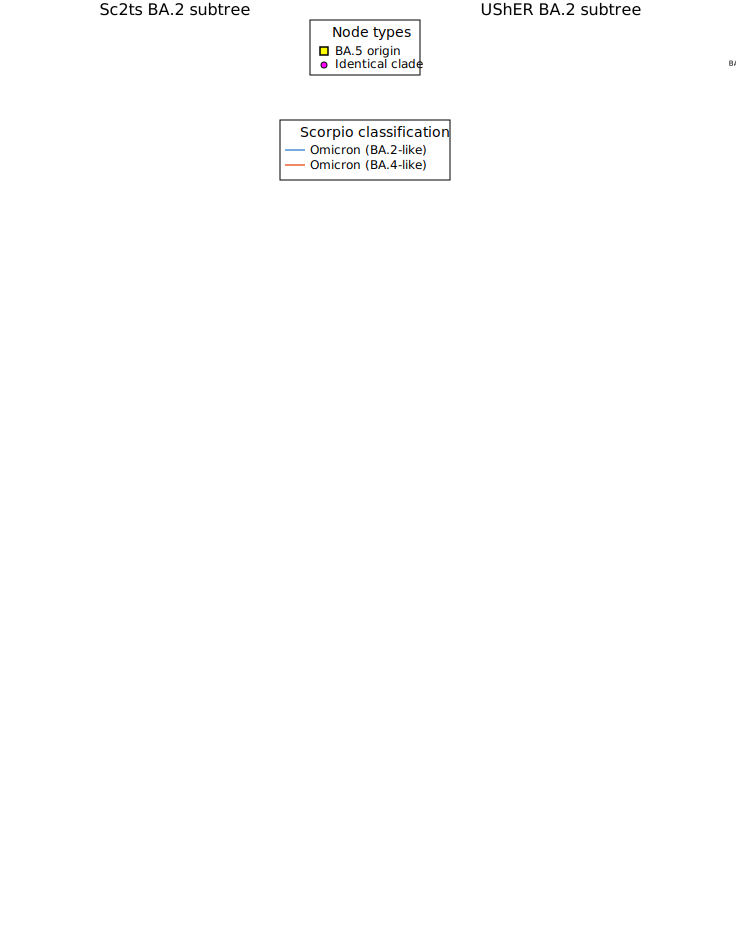

In [20]:
def ba2_legend(colours, labels):
    return (
        '<g transform="translate(280 120)">' +
        '<rect x="0" y="0" width="170" height="60" fill="white" stroke="black" />' +
        '<text x="20" y="17" font-style="italic" font-size="14px">Scorpio classification</text>' +
        "".join([
            (f'<line x1="5" x2="25" y1="{30 + 15*i}" y2="{30 + 15*i}" stroke="{c}" stroke-width="2" />'
             f'<text x="30" y="{34 + 15 * i}" font-size="12px">{label}</text>'
            )
            for i, (c, label) in enumerate(zip(colours, labels))
        ]) +
        '</g>' +
    
        '<g transform="translate(310 20)">' +
        '<rect x="0" y="0" width="110" height="55" fill="white" stroke="black" />' +
        '<text x="22" y="17" font-style="italic" font-size="14px">Node types</text>' +
        '<rect x="10" y="27" height="8" width="8" stroke="black" stroke-width="1.5" fill="#FFFF00"/>' +
        '<text x="25" y="35" font-size="12px">BA.5 origin</text>' +
        '<circle cx="14" cy="45" r="3" stroke="black" stroke-width="1" fill="magenta" />' +
        '<text x="25" y="48" font-size="12px">Identical clade</text>' +
        '</g>'
    )
name = "BA.2 subtree"

plot_tanglegram(
    two_tree_ts[name],
    name, orders[name],
    pangos,
    size=(700, 950),
    x_ticks={k: v for k, v, in x_ticks.items() if 40 < k < 450},
    time_scale="rank", 
    line_gap=30,
    legend_func=ba2_legend,
    sample_fontsize="7px",
    path=f'../figures/tanglegram_{name.replace(" ", "_")}.svg',
)


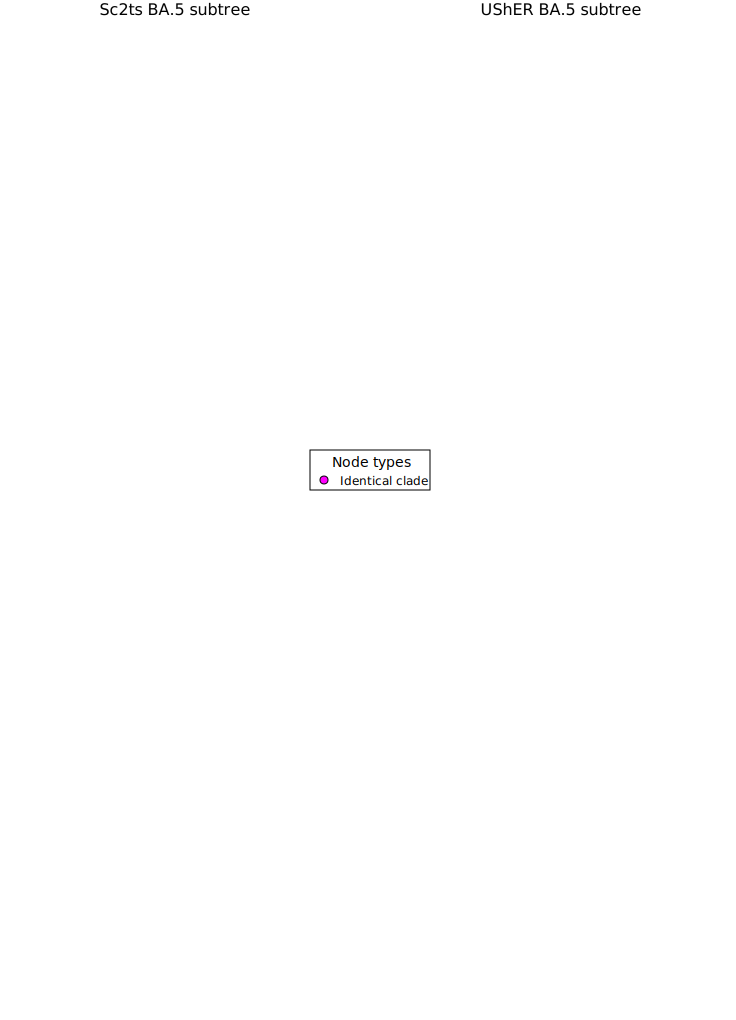

In [23]:
name = "BA.5 subtree"

def ba5_legend(colours, labels):
    return (
        '<g transform="translate(310 450)">' +
        '<rect x="0" y="0" width="120" height="40" fill="white" stroke="black" />' +
        '<text x="22" y="17" font-style="italic" font-size="14px">Node types</text>' +
        '<circle cx="14" cy="30" r="4" stroke="black" stroke-width="1" fill="magenta" />' +
        '<text x="30" y="35" font-size="12px">Identical clade</text>' +
        '</g>'
    )

plot_tanglegram(
    two_tree_ts[name], name, orders[name], pangos,
    size=(700, 1020),
    x_ticks={k: v for k, v, in x_ticks.items() if 20 < k < 700}, time_scale="rank", 
    legend_func=ba5_legend,
    line_gap=30,
    sample_fontsize="5px",
    path=f'../figures/tanglegram_{name.replace(" ", "_")}.svg',
)